In [1]:
# With the same augmentation, we are going to try vgg and resnet

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%d%m%Y-%H%M")

In [2]:
### Preparing the dataframe 
import pandas as pd
import glob
from pathlib import Path
import matplotlib.pyplot as plt 





In [3]:

#/Users/krish/Library/CloudStorage/GoogleDrive-krishthephysicist@gmail.com/My Drive/ljmu/1.data
root_path =  r'/Users/krish/ljmu/'
result_root = root_path + '3.results/13112022-ResNet50-afo/'
Path(result_root).mkdir(parents=True, exist_ok=True)

# # Incase you run in colab
# root_path =  r'/content/drive/MyDrive/ljmu/'
# result_root = root_path + '3.results/06112022-VGGNet/'
# Path(result_root).mkdir(parents=True, exist_ok=True)

In [14]:
train = pd.read_csv(root_path+'1.data/afo/tiled/afo_train_df.csv')


In [15]:
train['humans'] = train['humans'].apply(lambda x: str(x))

In [17]:
# Generator
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(train, 
                                   test_size = 0.15, 
                                   random_state = 2018,
                                   stratify = train['humans']) # Stratify makes sure that the subset of training and testing data returned keeps the same class propotion of the main dataframe
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 39781 validation 7021


In [18]:
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

In [19]:
# Rotation_range - random rotation within the angle mentioned
# Random_shifts - shifts 20% at max. to the horizontal and vertical(reduce to 10% as already diverse data)
# Random_flip - random flips 
# fill_mode - fill the blank pixels, when augmenting with the nearest color
datagen = ImageDataGenerator(rotation_range = 360,
                             width_shift_range=0.1, height_shift_range=0.1,
                             #horizontal_flip=True, vertical_flip=True, # Isnt much useful for us
                             brightness_range=[0.5,1.5],
                             rescale=1./255.,fill_mode='nearest')

train_generator = datagen.flow_from_dataframe(dataframe=train_df, x_col = 'name', y_col = 'humans', class_mode='binary', target_size=(224 , 224), batch_size=16)
valid_generator = datagen.flow_from_dataframe(dataframe=valid_df, x_col = 'name', y_col = 'humans', class_mode='binary', target_size=(224 , 224), batch_size=16)

Found 39781 validated image filenames belonging to 2 classes.
Found 7021 validated image filenames belonging to 2 classes.


### Strating with inception

In [20]:
import tensorflow as tf

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [21]:
# Why I have this as false : https://stackoverflow.com/questions/46036522/defining-model-in-keras-include-top-true
# So that I can list out the number of classes that I have

vgg_16 = tf.keras.applications.resnet50.ResNet50(input_shape=(224 , 224, 3),
                                           include_top=False, 
                                           weights='imagenet')

model = Sequential()
model.add(vgg_16)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))



model.add(Dense(1, activation="sigmoid" , name="classification"))

Metal device set to: Apple M1


2022-11-15 23:56:57.889202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 23:56:57.889593: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9), 
            loss='BinaryCrossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                        

In [23]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta = 0.5)

In [24]:
class_weight = {0:1.,1:1.}
history = model.fit(train_generator, validation_data = valid_generator, epochs = 10, class_weight=class_weight,callbacks=[es])

Epoch 1/10


2022-11-15 23:57:06.110532: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-15 23:57:07.267547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2487/2487 [==============================] - ETA: 0s - loss: 0.3582 - accuracy: 0.8441

2022-11-16 00:22:36.148041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2487/2487 [==============================] - 1626s 652ms/step - loss: 0.3582 - accuracy: 0.8441 - val_loss: 0.2063 - val_accuracy: 0.9311
Epoch 2/10
2487/2487 [==============================] - 1635s 657ms/step - loss: 0.2170 - accuracy: 0.9269 - val_loss: 0.1860 - val_accuracy: 0.9383
Epoch 3/10
2487/2487 [==============================] - 1676s 674ms/step - loss: 0.2001 - accuracy: 0.9312 - val_loss: 0.1761 - val_accuracy: 0.9405


In [25]:
model.save(result_root+date_time+'-ResNet_after_tiling+augmentation_10epochs_afo')

INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/13112022-ResNet50-afo/15112022-2354-ResNet_after_tiling+augmentation_10epochs_afo/assets


INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/13112022-ResNet50-afo/15112022-2354-ResNet_after_tiling+augmentation_10epochs_afo/assets


439/439 - 93s - loss: 0.1818 - accuracy: 0.9385 - 93s/epoch - 211ms/step


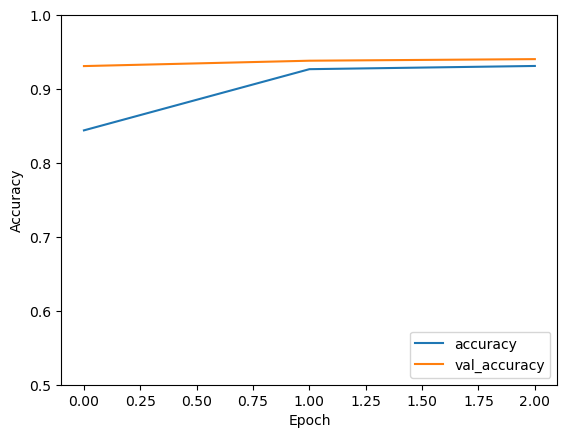

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(valid_generator, verbose=2)

plt.savefig(result_root+date_time+'-ResNet_accuracy_after_tiling_augmentation_afo.png')